In [1]:
from data.data_loader import Dataset_Custom, Dataset_Pred
from torch.utils.data import DataLoader
import pandas as pd
import os
import torch
from tqdm import tqdm

# model을 import
from models.model import Informer

In [2]:

def nmae(y_pred, y_true, reduction='mean'):
    if reduction == 'mean':
        return torch.mean(torch.abs(y_pred - y_true)/y_true)
    elif reduction == 'sum':
        return torch.sum(torch.abs(y_pred - y_true)/y_true)


----------------------------------------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from datetime import timedelta
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

# model을 import
from models.model import Informer

In [3]:
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean
        
# 시간 특징을 freq에 따라 추출
def time_features(dates, freq='h'):
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    dates['hour'] = dates.date.apply(lambda row:row.hour,1)
    dates['minute'] = dates.date.apply(lambda row:row.minute,1)
    dates['minute'] = dates.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return dates[freq_map[freq.lower()]].values

# 한번의 batch를 실행하는 코드
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y

In [4]:
class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None, scale=True, freq='h'):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe
        
        self.scale = scale
        self.freq = freq
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]

        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]


        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

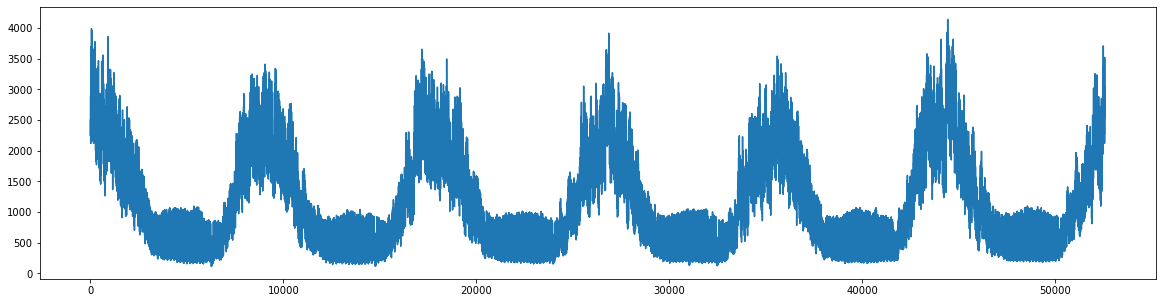

,date,공급량
0,2013-01-01 01:00:00,2497.129
1,2013-01-01 02:00:00,2363.265
2,2013-01-01 03:00:00,2258.505
3,2013-01-01 04:00:00,2243.969
4,2013-01-01 05:00:00,2344.105


In [5]:
data = pd.read_csv("./data/gas_A.csv")
plt.figure(figsize=(20,5))
plt.plot(data["공급량"])
plt.show()
data.head()

In [1]:
def nmae(y_pred, y_true, reduction='mean'):
    if reduction == 'mean':
        return torch.mean(torch.abs(y_pred - y_true)/y_true)
    elif reduction == 'sum':
        return torch.sum(torch.abs(y_pred - y_true)/y_true)

In [6]:
def prediction(model, df_test, pred_len):
    delta = df_test["date"][1] - df_test["date"][0]
    for i in range(pred_len):
        df_test = df_test.append({"date":df_test["date"].iloc[-1]+delta}, ignore_index=True)
    df_test = df_test.fillna(0)
    df_test.tail()


    df_test_x = df_test.iloc[-seq_len-pred_len:-pred_len].copy()
    df_test_y = df_test.iloc[-label_len-pred_len:].copy()

    df_test_numpy = df_test.to_numpy()[:,1:].astype("float")
    test_time_x = time_features(df_test_x, freq='h') #인풋 타임 스템프
    test_data_x = df_test_numpy[-seq_len-pred_len:-pred_len] #인풋 데이터


    test_time_y = time_features(df_test_y, freq='h') #아웃풋 타임스템프
    test_data_y =df_test_numpy[-label_len-pred_len:]
    test_data_y[-pred_len:] = np.zeros_like(test_data_y[-pred_len:]) #예측하는 부분을 0으로 채워준다.

    test_time_x = test_time_x
    test_time_y = test_time_y
    test_data_y = test_data_y.astype(np.float64)
    test_data_x = test_data_x.astype(np.float64)

    _test = [(test_data_x,test_data_y,test_time_x,test_time_y)]
    _test_loader = DataLoader(_test,batch_size=1,shuffle=False)

    preds = []

    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(_test_loader):

        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)
        outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
        preds = outputs.detach().cpu().numpy()
    df_test.iloc[-pred_len:, 1:] = preds.squeeze() 
    return df_test




In [7]:
pre = pd.read_csv("./data/gas_A.csv")
pre.rename(columns = {'공급량' : 'value'}, inplace = True)
pre.tail()

,date,value
52579,2018-12-31 20:00:00,3040.868
52580,2018-12-31 21:00:00,2973.577
52581,2018-12-31 22:00:00,2840.272
52582,2018-12-31 23:00:00,2692.385
52583,2019-01-01 00:00:00,2583.340


In [28]:
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
enc_in = 1
dec_in = 1
c_out = 1
pred_len = 24*30

seq_len = pred_len#인풋 크기
label_len = pred_len#디코더에서 참고할 크기
pred_len = pred_len#예측할 크기

batch_size =32 
shuffle_flag = False 
num_workers = 0
drop_last = False
device = torch.device("cuda:0")

model = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, device = device).to(device)
preds = np.array([], dtype=np.float32)
companies = "ABCDEGH"

for company in companies:
    data = pd.read_csv(f"./data/gas_{company}.csv")
    data.rename(columns = {'공급량' : 'value'}, inplace = True)

   
    model.load_state_dict(torch.load(f'./model{company}.pth'))

    minmax_scaler = MinMaxScaler()
    standard_scaler = StandardScaler()


    cols_data = data.columns[1:]
    data[cols_data]= minmax_scaler.fit_transform(data[cols_data])
    data[cols_data]= standard_scaler.fit_transform(data[cols_data].values)
    data["date"] = pd.to_datetime(data["date"].values)

    for i in range(int(2160/pred_len)):
        data = prediction(model, data, pred_len)
        
    data[cols_data]= standard_scaler.inverse_transform(data[cols_data])
    data[cols_data]= minmax_scaler.inverse_transform(data[cols_data])
    preds = np.append(preds, np.array(data[-2160:]["value"]))
    a = f"test{company} = data.copy()"
    exec(a)

In [29]:
model_name = "informer"
submission = pd.read_csv('submission/sample_submission.csv')
submission['공급량'] = preds
submission.to_csv(f'submission/submission_{model_name}.csv', index=False)

In [30]:
testA.tail()

,date,value
54739,2019-03-31 20:00:00,1191.498438
54740,2019-03-31 21:00:00,1113.126497
54741,2019-03-31 22:00:00,1041.045205
54742,2019-03-31 23:00:00,978.465347
54743,2019-04-01 00:00:00,886.006313


In [21]:
preds = np.array([], dtype=np.float32)
preds = np.append(preds, np.array(data[-390*24:-25*24]["value"]))

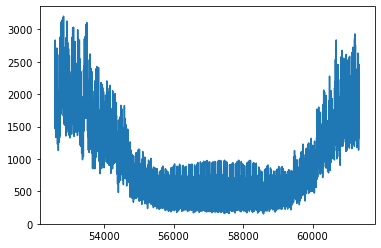

In [12]:
plt.plot(test["value"])
plt.show()

array([2109.3872064 , 1724.32570459, 1478.85636364, ..., 1896.71341448,
       1785.54588604, 1636.07112691])

In [17]:
con = pd.concat([data, test], axis=0)

In [18]:
len(con), len(data), len(test)

(70704, 61944, 8760)